# Minimal Example for Computers with Low Resources - Neutron Reflectivity
**(MD2reflect version 0.15)**

In [1]:
# Run this cell if this notebook is in another folder than the module
import sys
sys.path.append("..")

**0. Load the module:**

In [2]:
from md2reflect import *

**1. Create the trajectory generator that will keep loading the trajectory a few frames at a time:**

In [3]:
import os

In [4]:
trajectory_chunks = chop_trajectory(os.path.join("..", "simulations", "traj3.dcd"), 
                                    filename_topology = os.path.join("..", "simulations", "traj3_first_frame.pdb"),
                                    skip_frames = 600, frame_chunk = 4, chunk_fix=True)

**2. Load only the first chunk as a sample to get the binning, display molecules, etc:**

In [5]:
chunk = next(trajectory_chunks)

**3. Define binning along the z axis:**

In [6]:
zbin_interval, box_zlength, zbins_number, zbin_volume = select_zbinning(chunk)
different_elements = get_elements(chunk)

Length of simulation box in x direction:  49.85000133514404 Å
Length of simulation box in y direction:  49.85000133514404 Å
Length of simulation box in z direction:  160.0 Å 

Thickness of z slices:  0.5 Å
Number of z bins:  320
Volume of z bins:  1242.51127243042 Å^3


**4. Reload the trajectory chunk generator:**

It is necessary to reload the trajectory chunk generator so that it will start from the beginning and not the second chunk.

In [7]:
trajectory_chunks = chop_trajectory(os.path.join("..", "simulations", "traj3.dcd"), 
                                    filename_topology = os.path.join("..", "simulations", "traj3_first_frame.pdb"),
                                    skip_frames = 600, frame_chunk = 4, chunk_fix=True)

**5. Count the number of atoms along the z axis for each element in the trajectory (counts all the chunks):**

In [8]:
number_atoms_elements_allframes = count_number_atoms_chunks(trajectory_chunks, zbins_number)

0:00:00.655133 (hh:mm:ss.ss) for one frame. 

Number of chunks:  5.0   Total number of frames:  17.0
Actual running time: 0:00:03.569726 (hh:mm:ss.ss)


**6. Calculate the atomic number density along the z axis for each element in the trajectory (counts all the chunks):**

In [9]:
number_density_elements_allframes = calculate_number_density_elements(number_atoms_elements_allframes, zbin_volume)

**7. Fetch the coherent scattering lengths for each element in the simulation (we will use the last trajectory chunk):**

In [10]:
bc_table_neutrons = get_elements_bc_neutrons(chunk)

**8. Calculate the scattering length density along the z axis for each element in the simulation:**

In [11]:
SLD_elements = calculate_SLD_elements(number_density_elements_allframes, bc_table_neutrons)

**9. Indicate the substrate element:**  
With this method is must be an element unique to the substrate and not present in the sample.

In [12]:
substrate_element = "copper"

**10. Calculate the total scattering length density of the simulation along the z axis, and also without the substrate contribution:**

In [13]:
SLD_total, SLD_total_no_substrate = calculate_SLD_total(SLD_elements, substrate_element)

**11. Build the substrate and environment layers:**  
The substrate element is specified by the user. The environment SLD is estimated averaging a range in the simulation SLD that is close to the bulk.

In [14]:
substrate_layers = build_substrate_layer(substrate_element, probe="neutrons")
environment_layers = build_average_environmental_layer(SLD_total_no_substrate, 60, 100, 
                                                       distance_input=True, zbin_interval=zbin_interval)

 Substrate:
Density = 8.96 g/cm^3
Mass = 63.546 g/mol

Number density = 0.08491233191451862 Å^-3
bc = ( 7.718 +i 0.0 ) fm
SLD substrate = ( 6.553533777162547e-06 +i 0.0 ) Å^-2
SLD environment = ( 8.631462844012612e-07 +i 0.0 ) Å^-2


**12. Build the SLD adding the substrate and environment layers to the simulation:**  
Take the total scattering length density of the simulation without its substrate contribution, select the relevant range, and add the theoretical substrate and environment layers.

In [15]:
SLD_tuned_left = build_SLD_left(SLD_total_no_substrate, 41, 160, substrate_layers, environment_layers)

**13. Calculate the reflectivity of the constructed scattering length density:**  

In [16]:
reflectivity_MD_left = calculate_reflectivity(SLD_tuned_left, zbin_interval, incoming_beam="right",
                                              reflectivity_function="theoretical")

**14. Save the reflectivity data:**

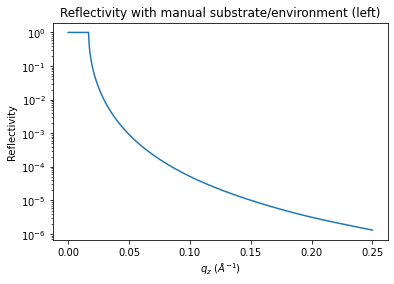

In [17]:
save_reflectivity_left(reflectivity_MD_left, filename="R_tuned_left_elements", show=True)

-----